<a href="https://colab.research.google.com/github/yunju-1118/ESAA/blob/OB/ESAA_week04_2_TextAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **텍스트 분석**

## **텍스트 분류 실습 - 20 뉴스그룹 분류**
텍스트 분류는 특정 문서의 분류를 학습 데이터를 통해 모델을 생성한 뒤 이 학습 모델을 이용해 다른 문서의 분류를 예측하는 것이다.

텍스트를 피처 벡터화로 변환하면 일반적으로 희소 행렬 형태가 된다. 그리고 이러한 희소 행렬에 분류를 효과적으로 잘 처리할 수 있는 알고리즘은 로지스틱 회귀, 선형 서포트 벡터 머신, 나이브 베이즈 등이 있다. 텍스트를 기반으로 분류를 수행할 때는 먼저 텍스트를 정규화한 뒤, 피처 벡터화를 적용한다. 그리고 그 이후에 적합한 머신러닝 알고리즘을 적용해 분류를 학습/예측.평가한다.

### **텍스트 정규화**


In [1]:
from sklearn.datasets import fetch_20newsgroups

news_data = fetch_20newsgroups(subset='all', random_state=156)

fetch_20newsgroups( )는 사이킷런의 다른 데이터 세트 예제와 같이 파이썬 딕셔너리와 유사한 Bunch 객체를 반환한다.

In [2]:
print(news_data.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [3]:
import pandas as pd

print('target 클래스의 값과 분포도 \n', pd.Series(news_data.target).value_counts().sort_index())
print('target 클래스의 이름들 \n', news_data.target_names)

target 클래스의 값과 분포도 
 0     799
1     973
2     985
3     982
4     963
5     988
6     975
7     990
8     996
9     994
10    999
11    991
12    984
13    990
14    987
15    997
16    910
17    940
18    775
19    628
Name: count, dtype: int64
target 클래스의 이름들 
 ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [4]:
print(news_data.data[0])

From: egreen@east.sun.com (Ed Green - Pixel Cruncher)
Subject: Re: Observation re: helmets
Organization: Sun Microsystems, RTP, NC
Lines: 21
Distribution: world
Reply-To: egreen@east.sun.com
NNTP-Posting-Host: laser.east.sun.com

In article 211353@mavenry.altcit.eskimo.com, maven@mavenry.altcit.eskimo.com (Norman Hamer) writes:
> 
> The question for the day is re: passenger helmets, if you don't know for 
>certain who's gonna ride with you (like say you meet them at a .... church 
>meeting, yeah, that's the ticket)... What are some guidelines? Should I just 
>pick up another shoei in my size to have a backup helmet (XL), or should I 
>maybe get an inexpensive one of a smaller size to accomodate my likely 
>passenger? 

If your primary concern is protecting the passenger in the event of a
crash, have him or her fitted for a helmet that is their size.  If your
primary concern is complying with stupid helmet laws, carry a real big
spare (you can put a big or small head in a big helmet, bu

텍스트 데이터를 확인해보면 뉴스그룹 기사의 내용뿐만 아니라 뉴스그룹 제목, 작성자, 소속, 이메일 등의 다양한 정보를 가지고 있다. 이 중에서 내용을 제외하고 제목 등의 다른 정보는 제거한다. 제목과 소속, 이메일 주소 등의 헤더와 푸터 정보들은 뉴스그룹 분류의 Target 클래스 값과 유사한 데이터를 가지고 있는 경우가 많기 때문이다. remove 파라미터를 이용하면 뉴스 그룹 기사의 헤더(header), 푸터(footer) 등을 제거할 수 있다.

또한, fetch_20newsgroups( )는 subset 파라미터를 이용해 학습 데이터 세트와 테스트 데이터 세트를 분리해 내려받을 수 있다.

In [5]:
from sklearn.datasets import fetch_20newsgroups

# subset='train'으로 학습용 데이터만 추출, remove=('headers', 'footers', 'quotes')
train_news = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'),
                                random_state=156)
X_train = train_news.data
y_train = train_news.target

# subset='test'으로 학습용 데이터만 추출, remove=('headers', 'footers', 'quotes')
test_news = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'),
                                random_state=156)
X_test = test_news.data
y_test = test_news.target

print('학습 데이터 크기 {0}, 테스트 데이터 크기 {1}'.format(len(train_news.data),
                                             len(test_news.data)))

학습 데이터 크기 11314, 테스트 데이터 크기 7532


### **피처 벡터화 변환과 머신러닝 모델 학습/예측/평가**

**CountVectorizer**를 이용해 학습 데이터의 텍스트를 피처 벡터화하자. 테스트 데이터에서 CountVectorizer를 적용할 때는 반드시 학습 데이터를 이용해 fit( )이 수행된 CountVectorizer 객체를 이용해 테스트 데이터를 변환(transform) 해야 한다.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# Count Vectorization으로 피처 벡터화 변환 수행
cnt_vect = CountVectorizer()
cnt_vect.fit(X_train)
X_train_cnt_vect = cnt_vect.transform(X_train)

# 학습 데이터로 fit( )된 CountVectorizer를 이용해 테스트 데이터를 피처 벡터화 변환 수행
X_test_cnt_vect = cnt_vect.transform(X_test)

print('학습 데이터 텍스트의 CountVectorizer Shape:', X_train_cnt_vect.shape)

학습 데이터 텍스트의 CountVectorizer Shape: (11314, 101631)


이렇게 피처 벡터화된 데이터에 로지스틱 회귀를 적용해 뉴스그룹에 대한 분류를 예측해보자

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# LogisticRegression을 이용해 학습/예측/평가 수행
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train_cnt_vect, y_train)
pred = lr_clf.predict(X_test_cnt_vect)

print('CountVectorized Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

CountVectorized Logistic Regression의 예측 정확도는 0.617


이번에는 **TF-IDF** 기반으로 벡터화하여 예측 모델을 수행해보자.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF 벡터화를 적용해 학습 데이터 세트와 테스트 데이터 세트 변환
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train)
X_train_tfidf_vect = tfidf_vect.transform(X_train)
X_test_tfidf_vect = tfidf_vect.transform(X_test)

# LogisticRegression을 이용해 학습/예측/평가 수행
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train_tfidf_vect, y_train)
pred = lr_clf.predict(X_test_tfidf_vect)
print('TF-IDF Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

TF-IDF Logistic Regression의 예측 정확도는 0.678


TF-IDF가 단순 카운트 기반보다 훨씬 높은 예측 정확도를 제공한다. 일반적으로 문서 내에 텍스트가 많고 많은 문서를 가지는 텍스트 분석에서 카운트 벡터화보다는 TF-IDF 벡터화가 좋은 예측 결과를 도출한다.

텍스트 분석에서 머신러닝 모델의 성능을 향상시키는 중요한 2가지 방법은 최적의 ML 알고리즘을 선택하는 것과 최상의 피처 전처리를 수행하는 것이다.

앞의 TF-IDF 벡터화에서 더 다양한 파라미터를 적용해보자.

In [9]:
# stop words 필터링을 추가하고 ngram을 기본 (1,1)에서 (1,2)로 변경해 피처 벡터화 적용
tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=300)
tfidf_vect.fit(X_train)
X_train_tfidf_vect = tfidf_vect.transform(X_train)
X_test_tfidf_vect = tfidf_vect.transform(X_test)

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train_tfidf_vect, y_train)
pred = lr_clf.predict(X_test_tfidf_vect)
print('TF-IDF Vectorized Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

TF-IDF Vectorized Logistic Regression의 예측 정확도는 0.690


이번에는 GridSearchCV를 이용해 로지스틱 회귀의 하이퍼 파라미터 최적화를 수행해보자.

In [10]:
from sklearn.model_selection import GridSearchCV

# 최적 C 값 튜닝 수행, CV는 3 폴드 세트로 설정.
params = {'C':[0.01, 0.1, 1, 5, 10]}
grid_cv_lr = GridSearchCV(lr_clf, param_grid=params, cv=3,
                          scoring='accuracy', verbose=1)
grid_cv_lr.fit(X_train_tfidf_vect, y_train)
print('Logistic Regression best C parameter: ', grid_cv_lr.best_params_)

# 최적 C 값으로 학습된 grid_cv로 예측 및 정확도 평가
pred = grid_cv_lr.predict(X_test_tfidf_vect)
print('TF-IDF Vectorized Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test,pred)))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Logistic Regression best C parameter:  {'C': 10}
TF-IDF Vectorized Logistic Regression의 예측 정확도는 0.704


### **사이킷런 파이프라인 사용 및 GridSearchCV와의 결합**

사이킷런 Pipeline 클래스를 이용하면 피처 벡터화와 ML 알고리즘 학습/예측을 위한 코드 작성을 한 번에 진행할 수 있다. 이를 통해 데이터의 전처리와 머신러닝 학습 과정을 통일된 API 기반에서 처리할 수 있어 더 직관적인 ML 코드를 생성할 수 있으며, 대용량 데이터의 피처 벡터화 결과를 별도 데이터로 저장하지 않고 스트림 기반에서 바로 머신러닝 알고리즘의 데이터로 입력할 수 있어 수행시간을 절약할 수 있다.

다음은 위에서 텍스트 분류 예제 코드를 Pipeline을 이용해 다시 작성한 코드이다.

In [35]:
from sklearn.pipeline import Pipeline

In [36]:
pipeline = Pipeline([('tfidf_vect', TfidfVectorizer(stop_words='english')),
                     ('lr_clf', LogisticRegression(random_state=156))])

In [13]:
from sklearn.pipeline import Pipeline

# TfidfVectorizer 객체를 tfidf_vect로, LogisticRegression을 lr_clf로 생성하는 Pipeline 생성
pipeline = Pipeline([('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=300)),
                     ('lr_clf', LogisticRegression(solver='liblinear', C=10))])

# 별도의 TfidfVectorizer 객체의 fit( ), transform( )와
# LogisticRegression의 fit( ), predict( )가 필요없음
# pipeline의 fit( )과 predict( ) 만으로 한 번에 피처 벡터화와 ML 학습/예측이 가능

pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)
print('Pipeline을 통한 Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

Pipeline을 통한 Logistic Regression의 예측 정확도는 0.704


사이킷런은 GridSearchCV 클래스의 생성 파라미터로 Pipeline을 입력해 Pipeline 기반에서도 하이퍼 파라미터 튜닝을 GridSearchCV 방식으로 진행할 수 있도록 한다. 이렇게 하면 피처 벡터화를 위한 파라미터와 ML 알고리즘의 하이퍼 파라미터를 모두 한 번에 GridSearchCV를 이용해 최적화 할 수 있다.

Piepline + GridSearchCV를 적용할 때 유의할 점은 모두의 파라미터를 최적화하려면 너무 많은 튜닝 시간이 소모된다는 점이다. 피처 벡터화에 사용되는 파라미터와 GridSearchCV 하이퍼 파라미터를 합치면 최적화를 위한 너무 많은 경우의 수가 발생하기 쉽다.

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(stop_words='english')),
    ('lr_clf', LogisticRegression())
])

# Pipeline에 기술된 각각의 객체 변수에 언더바(_) 2개를 연달아 붙여
# GridSearchCV에 사용될 파라미터/하이퍼파라미터 이름과 값을 설정
params = {'tfidf_vect__ngram_range': [(1,1),(1,2),(1,3)],
          'tfidf_vect__max_df': [100,300,700],
          'lr_clf__C': [1,5,10]}

# GridSearchCV 생성자에 Estimator가 아닌 Pipeline 객체 입력
grid_cv_pipe = GridSearchCV(pipeline, param_grid = params, cv=3, scoring='accuracy', verbose=1)
grid_cv_pipe.fit(X_train, y_train)
print(grid_cv_pipe.best_params_, grid_cv_pipe.best_score_)

pred = grid_cv_pipe.predict(X_test)
print('Pipeline을 통한 Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

**로지스틱 회귀** 외에 **서포트 벡터 머신**과 **나이브 베이즈** 알고리즘도 희소 행렬 기반의 텍스트 분류에 자주 사용되는 머신러닝 알고리즘이다.

## **감성 분석**

IMDB 영화 사이트의 영화평을 이용해 텍스트를 분석하여 감성 분석 결과가 긍정 또는 부정인지를 예측하는 모델을 만들어보자.

In [15]:
import pandas as pd

review_df = pd.read_csv('labeledTrainData.tsv', header=0, sep="\t", quoting=3)
review_df.head(3)

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."


In [16]:
print(review_df['review'][0])

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [17]:
import re

# <br> html 태그는 replace 함수로 공백으로 변환
review_df['review'] = review_df['review'].str.replace('<br />', ' ')

# 파이썬의 정규 표현식 모듈은 re를 이용해 영어 문자열이 아닌 모두 공백으로 변환
review_df['review'] = review_df['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x))

결정 값 클래스인 sentiment 칼럼을 별도로 추출해 결정 값 데이터 세트를 만들고, 원본 데이터 세트에서 id와 sentiment 칼럼을 삭제해 피처 데이터 세트를 생성한다.

In [18]:
from sklearn.model_selection import train_test_split

class_df = review_df['sentiment']
feature_df = review_df.drop(['id', 'sentiment'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(feature_df, class_df, test_size=0.3, random_state=156)

X_train.shape, X_test.shape

((3759, 1), (1611, 1))

Review 텍스트를 피처 벡터화한 후에 ML 분류 알고리즘을 적용해 예측 성능을 측정해보자. Pipeline 객체를 이용하면 이 두 가지를 한 번에 수행할 수 있다.

Count 벡터화를 통해 예측 성능을 측정해보자

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# 스톱 워드는 English, ngram은 (1,2)로 설정해 CountVectorization 수행
# Logistic Regression의 C는 10으로 설정

pipeline = Pipeline([
    ('cnt_vect', CountVectorizer(stop_words='english', ngram_range=(1,2))),
    ('lr_clf', LogisticRegression(solver='liblinear', C=10))
])

# Pipeline 객체를 이용해 fit(), predict()로 학습/예측/수행. predict_proba( )는 roc_auc_score 때문에 수행
pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:,1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test, pred),
                                                 roc_auc_score(y_test, pred_probs)))

예측 정확도는 0.8554, ROC-AUC는 0.9209


TF-IDF 벡터화를 통해 예측 성능을 측정해보자

In [20]:
# 스톱 워드는 English, ngram은 (1,2)로 설정해 TF-IDF 벡터화 수행
# Logistic Regression의 C는 10으로 설정

pipeline = Pipeline([
    ('tfifd_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
    ('lr_clf', LogisticRegression(solver='liblinear', C=10))
])

# Pipeline 객체를 이용해 fit(), predict()로 학습/예측/수행. predict_proba( )는 roc_auc_score 때문에 수행
pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:,1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test, pred),
                                                 roc_auc_score(y_test, pred_probs)))

예측 정확도는 0.8541, ROC-AUC는 0.9359


### **비지도학습 기반 감성 분석 소개**

비지도 감성 분석은 Lexicon을 기반으로 한다. Lexicon은 긍정 감성 또는 부정 감성의 정도를 의미하는 수치를 가지고 있으며 이를 감성 지수(Polarity score)라고 한다. 이 감성 지수는 단어의 위치나 주변 단어, 문맥, POS 등을 참고해 결정된다. 이러한 감성 사전을 구현한 대표격은 **NLTK 패키지**이다.

NLTK는 **WordNet**이라는 모듈을 제공한다. WordNet은 시맨틱 분석을 제공하는 어휘사전이다.

WordNet은 다양한 상황에서 같은 어휘라도 다르게 사용되는 어휘의 시맨틱 정보를 제공하며, 이를 위해 각각의 품사로 구성된 개별 단어를 Synset이라는 개념을 이용해 표현한다.

NLTK의 감성 사전이 감성에 대한 훌륭한 사전 역할을 제공하기도 하지만, 예측 성능이 그리 좋지 못하다는 단점도 존재한다. 따라서, 실제 업무의 적용은 NLTK 패키지가 아닌 다른 감성 사전을 이용하는 것이 일반적이다.

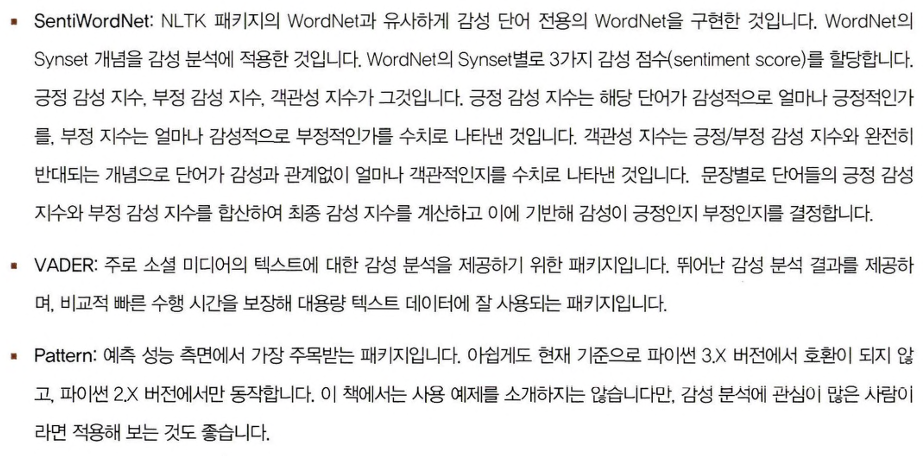

#### **SentiWordNet을 이용한 감성 분석**

**WordNet Synset과 SentiWordNet SentiSynset 클래스의 이해**

WordNet을 이용하기 위해서는 NLTK를 셋업한 후에 WordNet 서브 패키지와 데이터 세트를 내려받아야 한다.

In [21]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

NLTK의 모든 데이터 세트를 내려받은 후 WordNet 모듈을 임포트해서 'present' 단어에 대한 Synset을 추출한다. WordNet의 synsets( )는 파라미터로 지정된 단어에 대해 WordNet에 등재된 모든 Synset 객체를 반환한다.

In [22]:
from nltk.corpus import wordnet as wn

term = 'present'

# 'present'라는 단어로 wordnet의 synsets 생성
synsets = wn.synsets(term)
print('synsets() 반환 type:', type(synsets))
print('synsets() 반환 값 개수:', len(synsets))
print('synsets() 반환 값:', synsets)

synsets() 반환 type: <class 'list'>
synsets() 반환 값 개수: 18
synsets() 반환 값: [Synset('present.n.01'), Synset('present.n.02'), Synset('present.n.03'), Synset('show.v.01'), Synset('present.v.02'), Synset('stage.v.01'), Synset('present.v.04'), Synset('present.v.05'), Synset('award.v.01'), Synset('give.v.08'), Synset('deliver.v.01'), Synset('introduce.v.01'), Synset('portray.v.04'), Synset('confront.v.03'), Synset('present.v.12'), Synset('salute.v.06'), Synset('present.a.01'), Synset('present.a.02')]


In [23]:
for synset in synsets :
  print('##### Synset name:', synset.name(), '####')
  print('POS:', synset.lexname())
  print('정의:', synset.definition())
  print('표제어:', synset.lemma_names())

##### Synset name: present.n.01 ####
POS: noun.time
정의: the period of time that is happening now; any continuous stretch of time including the moment of speech
표제어: ['present', 'nowadays']
##### Synset name: present.n.02 ####
POS: noun.possession
정의: something presented as a gift
표제어: ['present']
##### Synset name: present.n.03 ####
POS: noun.communication
정의: a verb tense that expresses actions or states at the time of speaking
표제어: ['present', 'present_tense']
##### Synset name: show.v.01 ####
POS: verb.perception
정의: give an exhibition of to an interested audience
표제어: ['show', 'demo', 'exhibit', 'present', 'demonstrate']
##### Synset name: present.v.02 ####
POS: verb.communication
정의: bring forward and present to the mind
표제어: ['present', 'represent', 'lay_out']
##### Synset name: stage.v.01 ####
POS: verb.creation
정의: perform (a play), especially on a stage
표제어: ['stage', 'present', 'represent']
##### Synset name: present.v.04 ####
POS: verb.possession
정의: hand over formally
표제어: 

In [24]:
# synset 객체를 단어별로 생성
tree = wn.synset('tree.n.01')
lion = wn.synset('lion.n.01')
tiger = wn.synset('tiger.n.02')
cat = wn.synset('cat.n.01')
dog = wn.synset('dog.n.01')

entities = [tree,lion,tiger,cat,dog]
similarities = []
entity_names = [entity.name().split('.')[0] for entity in entities]

# 단어별 synset 들을 iteration 하면서 다른 단어들의 synset과 유사도 측정
for entity in entities:
  similarity = [round(entity.path_similarity(compared_entity),2) for compared_entity in entities]
  similarities.append(similarity)

similarities_df= pd.DataFrame(similarities,columns=entity_names,index=entity_names)
similarities_df

,tree,lion,tiger,cat,dog
tree,1.00,0.07,0.07,0.08,0.12
lion,0.07,1.00,0.33,0.25,0.17
tiger,0.07,0.33,1.00,0.25,0.17
cat,0.08,0.25,0.25,1.00,0.20
dog,0.12,0.17,0.17,0.20,1.00


In [25]:
import nltk
from nltk.corpus import sentiwordnet as swn

senti_synsets = list(swn.senti_synsets('slow'))
print('senti_synsets() 반환 type:', type(senti_synsets))
print('senti_synsets() 반환 값 개수:', len(senti_synsets))
print('senti_synsets() 반환 값:', senti_synsets)

senti_synsets() 반환 type: <class 'list'>
senti_synsets() 반환 값 개수: 11
senti_synsets() 반환 값: [SentiSynset('decelerate.v.01'), SentiSynset('slow.v.02'), SentiSynset('slow.v.03'), SentiSynset('slow.a.01'), SentiSynset('slow.a.02'), SentiSynset('dense.s.04'), SentiSynset('slow.a.04'), SentiSynset('boring.s.01'), SentiSynset('dull.s.08'), SentiSynset('slowly.r.01'), SentiSynset('behind.r.03')]


In [26]:
import nltk
from nltk.corpus import sentiwordnet as swn

father = swn.senti_synset('father.n.01')
print('father 긍정감성 지수:', father.pos_score())
print('father 부정감성 지수:', father.neg_score())
print('father 객관성 지수:', father.obj_score())
print('\n')
fabulous = swn.senti_synset('fabulous.a.01')
print('fabulous 긍정감성 지수:', fabulous.pos_score())
print('fabulous 부정감성 지수:', fabulous.neg_score())

father 긍정감성 지수: 0.0
father 부정감성 지수: 0.0
father 객관성 지수: 1.0


fabulous 긍정감성 지수: 0.875
fabulous 부정감성 지수: 0.125


In [27]:
from nltk.corpus import wordnet as wn
# NLTK PennTreebank Tag 기반으로 품사 태깅
def penn_to_wn(tag):
  if tag.startswith('J'):
    return wn.ADJ
  elif tag.startswith('N'):
    return wn.NOUN
  elif tag.startswith('R'):
    return wn.ADV
  elif tag.startswith('V'):
    return wn.VERB


In [28]:
# 문장 - 단어 토큰 - 품사 태깅 - SentiSynset - 감성 지수
# 합산 함수 생성 ; 총합산지수가 0 이상이면 긍정, 아니면 부정

from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

def swn_polarity(text):
  # 감성 지수 초기화
  sentiment = 0.0
  tokens_count = 0

  lemmatizer = WordNetLemmatizer()
  raw_sentences = sent_tokenize(text)
  for raw_sentences in raw_sentences:
    tagged_sentence = pos_tag(word_tokenize(raw_sentences))
    for word, tag in tagged_sentence:
      wn_tag = penn_to_wn(tag)
      if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        continue
      lemma = lemmatizer.lemmatize(word, pos=wn_tag)
      if not lemma:
        continue
        synsets = wn.synsets(lemma, pos=wn_tag)
        if not synsets:
          continue
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += (swn_synset.pos_socre() - swn.synset.neg_score())
        token_count +=1
    if not tokens_count:
      return 0

    if sentiment >= 0:
      return 1

    return 0

In [29]:
# 개별 감상평 텍스트에 함수 적용
# 정확도, 정밀도, 재현율 측정

review_df['preds'] = review_df['review'].apply(lambda x: swn_polarity(x))
y_target = review_df['sentiment'].values
preds = review_df['preds'].values

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix(y_target, preds))
print('정확도: ', np.round(accuracy_score(y_target, preds),4))
print('정밀도:', np.round(precision_score(y_target, preds),4))
print('재현율:', np.round(recall_score(y_target, preds),4))

[[2644    0]
 [2726    0]]
정확도:  0.4924
정밀도: 0.0
재현율: 0.0


In [31]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

senti_analyzer = SentimentIntensityAnalyzer()
senti_scores = senti_analyzer.polarity_scores(review_df['review'][0])
print(senti_scores)

{'neg': 0.13, 'neu': 0.743, 'pos': 0.127, 'compound': -0.7943}


In [32]:
def vader_polarity(review,threshold=0.1):
  analyzer = SentimentIntensityAnalyzer()
  scores = analyzer.polarity_scores(review)

  agg_score = scores['compound']
  final_sentiment = 1 if agg_score >= threshold else 0
  return final_sentiment

review_df['vader_preds'] = review_df['review'].apply(lambda x: vader_polarity(x,0.1))
y_target = review_df['sentiment'].values
vader_preds = review_df['vader_preds'].values

print(confusion_matrix(y_target, vader_preds))
print('정확도: ', np.round(accuracy_score(y_target, vader_preds),4))
print('정밀도:', np.round(precision_score(y_target, vader_preds),4))
print('재현율:', np.round(recall_score(y_target, vader_preds),4))

[[1430 1214]
 [ 373 2353]]
정확도:  0.7045
정밀도: 0.6597
재현율: 0.8632
